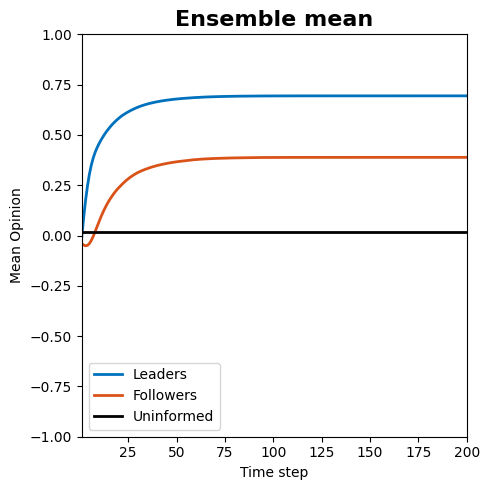

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os



# -----------------------------
# FUNCTIONS
# -----------------------------

def psi_sum(wk, wm, r_w):
    w_diff = wm - wk[:, np.newaxis]

    bool_psi = np.abs(w_diff) < r_w
    return np.sum(w_diff * bool_psi, axis=1)


# -----------------------------
# SET PARAMETERS
# -----------------------------

t_final = 20
dt = 0.1
steps = int(np.floor(t_final / dt))
dom = 1

n_l = 5
n_f = 6
n_u = 10

w_blue = 1
w_red = -1

# # Example 1
# k_ll, k_lf, k_lu = 1, 1, 0
# k_fl, k_ff, k_fu = 1, 1, 0
# k_ul, k_uf, k_uu = 0, 0, 1

# # Example 2
# k_ll, k_lf, k_lu = 1, 1, 1
# k_fl, k_ff, k_fu = 1, 1, 1
# k_ul, k_uf, k_uu = 0, 0, 1

# # Example 3
# k_ll, k_lf, k_lu = 1, 1, 1
# k_fl, k_ff, k_fu = 1, 1, 1
# k_ul, k_uf, k_uu = 1, 1, 1

# Example 4
k_ll, k_lf, k_lu = 1, 1, 0
k_fl, k_ff, k_fu = 1, 1, 1
k_ul, k_uf, k_uu = 0, 0, 0

r_w = 1.0

tau_blue = 1
tau_red = 0.1

sigma = 0



# -----------------------------
# SIMULATION FUNCTION
# -----------------------------

def simulate():
    w_l = np.zeros((steps, n_l))
    w_f = np.zeros((steps, n_f))
    w_u = np.zeros((steps, n_u))
    
    w_l[0, :] = -dom + (2 * dom) * np.random.rand(n_l)
    w_f[0, :] = -dom + (2 * dom) * np.random.rand(n_f)
    w_u[0, :] = -dom + (2 * dom) * np.random.rand(n_u)
    
    for k in range(steps - 1):
        psi_ll = psi_sum(w_l[k], w_l[k], r_w)
        psi_ff = psi_sum(w_f[k], w_f[k], r_w)
        psi_uu = psi_sum(w_u[k], w_u[k], r_w)
        psi_lf = psi_sum(w_l[k], w_f[k], r_w)
        psi_lu = psi_sum(w_l[k], w_u[k], r_w)
        psi_fl = psi_sum(w_f[k], w_l[k], r_w)
        psi_fu = psi_sum(w_f[k], w_u[k], r_w)
        psi_ul = psi_sum(w_u[k], w_l[k], r_w)
        psi_uf = psi_sum(w_u[k], w_f[k], r_w)
        
        # Integration step. Optimizable by precoumputing the constants
        dw_l = k_ll*psi_ll/n_l + k_lf*psi_lf/n_f + k_lu*psi_lu/n_u + tau_blue * (dom*w_blue - w_l[k])
        dw_f = k_fl*psi_fl/n_l + k_ff*psi_ff/n_f + k_fu*psi_fu/n_u + tau_red * (dom*w_red - w_f[k])
        dw_u = k_ul*psi_ul/n_l + k_uf*psi_uf/n_f + k_uu*psi_uu/n_u
        
        w_l[k+1] = w_l[k] + dt * dw_l
        w_f[k+1] = w_f[k] + dt * dw_f
        w_u[k+1] = w_u[k] + dt * dw_u
    
    return w_l, w_f, w_u



# -----------------------------
# SIMULATION and AVERAGING
# -----------------------------

runs = 100

ensemble_avg_leaders = np.zeros(steps)
ensemble_avg_followers = np.zeros(steps)
ensemble_avg_uninformed = np.zeros(steps)

np.random.seed(1234)

for run in range(runs):
    w_l, w_f, w_u = simulate()
    
    ensemble_avg_leaders += np.mean(w_l, axis=1)
    ensemble_avg_followers += np.mean(w_f, axis=1)
    ensemble_avg_uninformed += np.mean(w_u, axis=1)

ensemble_avg_leaders /= runs
ensemble_avg_followers /= runs
ensemble_avg_uninformed /= runs



# -----------------------------
# PLOTS
# -----------------------------

output_folder = 'figures/opinions-only'
os.makedirs(output_folder, exist_ok=True)

colors = {
    'gray': (0.7, 0.7, 0.7),
    'red': (0, 0.4470, 0.7410),
    'blue': (0.8500, 0.3250, 0.0980)
}

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title("Ensemble mean", fontweight="bold", fontsize=16)
ax.set_xlabel("Time step")
ax.set_ylabel("Mean Opinion")
ax.set_xlim(1, steps)
ax.set_ylim(-dom, dom)

ax.plot(range(1, steps+1), ensemble_avg_leaders, label="Leaders", color=colors["red"], linewidth=2)
ax.plot(range(1, steps+1), ensemble_avg_followers, label="Followers", color=colors["blue"], linewidth=2)
ax.plot(range(1, steps+1), ensemble_avg_uninformed, label="Uninformed", color="black", linewidth=2)

ax.legend()
plt.tight_layout()

output_file = os.path.join(output_folder, f"ensemble_avg-{runs}.svg")
plt.savefig(output_file)

# plt.show()